#  Tarea 3<br/>Regresión Logística, clasificación y Metropolis Hastings
#### Miguel Videla A.<br/>MA5204 Aprendizaje de Máquinas

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

#### 1. Data Visualization

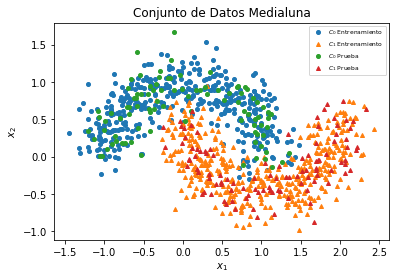

In [2]:
# Data Visualization
X, y = make_moons(n_samples=1000, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.plot(X_train[:,0][np.where(y_train == 0)], X_train[:,1][np.where(y_train == 0)], 'o', ms=4, label=r'$C_0$ Entrenamiento')
plt.plot(X_train[:,0][np.where(y_train == 1)], X_train[:,1][np.where(y_train == 1)], '^', ms=4, label=r'$C_1$ Entrenamiento')
plt.plot(X_test[:,0][np.where(y_test == 0)], X_test[:,1][np.where(y_test == 0)], 'o', ms=4, label=r'$C_0$ Prueba')
plt.plot(X_test[:,0][np.where(y_test == 1)], X_test[:,1][np.where(y_test == 1)], '^', ms=4, label=r'$C_1$ Prueba')
plt.legend(prop={'size': 6})
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Conjunto de Datos Medialuna')
plt.savefig('01-data_visualization', bbox_inches='tight', dpi=300)
plt.show()

#### 2. Logistic Regression

In [3]:
def sig(w, x):
    """
    Retorna la sigmoidea de (w @ x)
    """
    # agrego fila de unos
    x_tilda = np.c_[np.ones(x.shape[0]), x]
    a = x_tilda @ w    
    return 1 / (1 + np.exp(-a))

def rl_nll(w, x, y):
    """
    Log verosimilitud negativa del modelo de
    regresión logística.
    """
    # log verosimilitud negativa
    nll = -(y * np.log(sig(w, x)) + (1 - y) * np.log(1 - sig(w, x))).sum() 
    return nll

def jac_nll(w, x, y, rho=0.1):
    """
    Jacobiano de la NLL.
    """
    x_tilda = np.c_[np.ones(x.shape[0]), x]  
    return ((sig(w, x) - y) @ x_tilda)

In [4]:
w0 = np.zeros(X_train.shape[1] + 1) + 1e-6
args = (X_train, y_train)
opt = minimize(
    rl_nll,                  # funcion objetivo
    w0,                      # condicion inicial
    args,                    # argumentos fijos funcion objetivo
    jac=jac_nll,             # gradientes
    method='BFGS',           # metodo
    tol=1e-8,                # tolerancia numerica
    options={'disp': True, 'maxiter': 8000}) # opciones extra
w_opt = opt.x
print('Pesos optimos: ', w_opt)
print('NLL: ', opt.fun)

Optimization terminated successfully.
         Current function value: 236.621685
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
Pesos optimos:  [ 0.63306148  1.18978719 -4.70416841]
NLL:  236.62168458514628


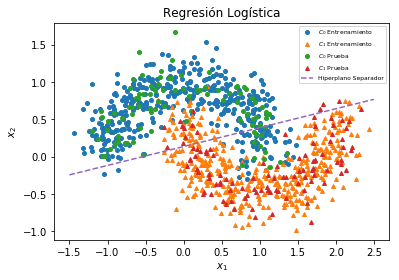

Logistic Regression Accuracy: 0.87


In [5]:
line_x = np.linspace(-1.5, 2.5, 100)
line_y = -opt.x[1] / opt.x[2] * line_x - opt.x[0] / opt.x[2]

plt.plot(X_train[:,0][np.where(y_train == 0)], X_train[:,1][np.where(y_train == 0)], 'o', ms=4, label=r'$C_0$ Entrenamiento')
plt.plot(X_train[:,0][np.where(y_train == 1)], X_train[:,1][np.where(y_train == 1)], '^', ms=4, label=r'$C_1$ Entrenamiento')
plt.plot(X_test[:,0][np.where(y_test == 0)], X_test[:,1][np.where(y_test == 0)], 'o', ms=4, label=r'$C_0$ Prueba')
plt.plot(X_test[:,0][np.where(y_test == 1)], X_test[:,1][np.where(y_test == 1)], '^', ms=4, label=r'$C_1$ Prueba')
plt.plot(line_x, line_y, '--', label='Hiperplano Separador')
plt.legend(prop={'size': 6})
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Regresión Logística')
plt.savefig('02-logistic_regression', bbox_inches='tight', dpi=300)
plt.show()
print('Logistic Regression Accuracy: {}'.format(accuracy_score(y_test, (sig(w_opt, X_test) >= 0.5).astype(int))))

#### 3. MCMC

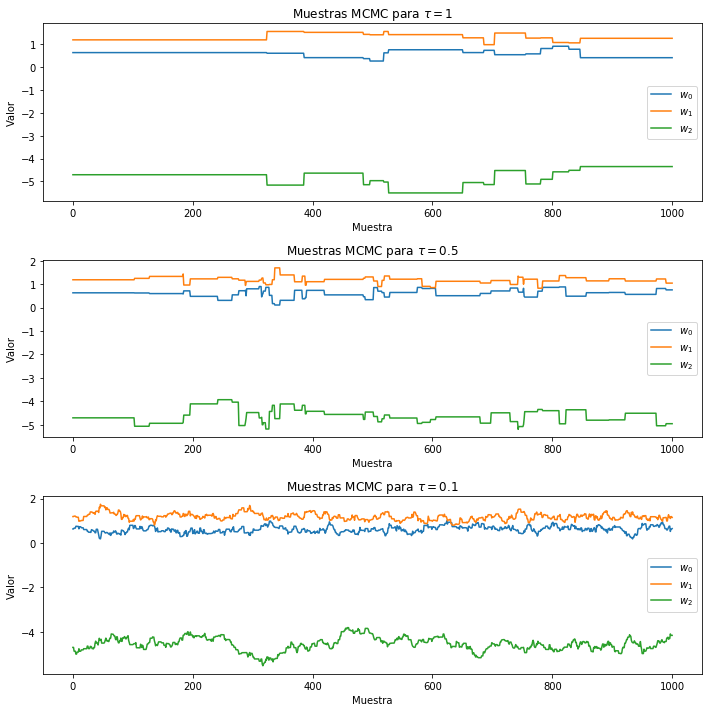

In [6]:
def log_gaussian(x, mu, cov):
    A = (2 * np.pi) ** (0.5 * cov.shape[0]) * np.linalg.det(cov) ** 0.5
    B = np.multiply((x - mu).T, np.multiply(np.linalg.inv(cov), x - mu))
    return np.log(A) + B

def metropolis_hastings(init_sample, data, n_iter=100, tau=0.4):
    generated_samples = [init_sample]
    for i in range(n_iter):
        candidate_sample = np.random.normal(generated_samples[-1], tau)
        log_num = -rl_nll(candidate_sample, data[0], data[1])
        log_denom = -rl_nll(generated_samples[-1], data[0], data[1])
        r = min(np.exp(log_num) / np.exp(log_denom), 1)
        if r > np.random.random():
            generated_samples.append(candidate_sample)
        else:
            sample = generated_samples[-1]
            generated_samples.append(sample)
    return generated_samples

mcmc_samples = []
tau_array = [1, 0.5, 0.1]
plt.figure(figsize=(10,10))
for i in range(len(tau_array)):
    generated_samples = metropolis_hastings(w_opt, [X_train, y_train], n_iter=1000, tau=tau_array[i])
    generated_samples = np.array(generated_samples)
    mcmc_samples.append(generated_samples)
    plt.subplot(3, 1, i+1)
    plt.plot(generated_samples[:,0], label=r'$w_0$')
    plt.plot(generated_samples[:,1], label=r'$w_1$')
    plt.plot(generated_samples[:,2], label=r'$w_2$')
    plt.title(r'Muestras MCMC para $\tau={}$'.format(tau_array[i]))
    plt.xlabel('Muestra')
    plt.ylabel('Valor')
    plt.legend()
plt.tight_layout()
plt.savefig('03-mcmc', bbox_inches='tight', dpi=300)
plt.show()

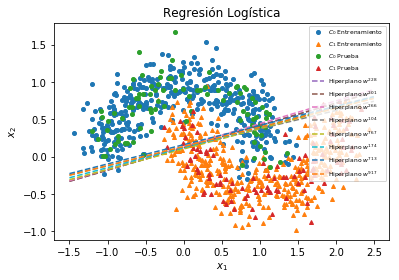

In [7]:
line_x = np.linspace(-1.5, 2.5, 100)

plt.plot(X_train[:,0][np.where(y_train == 0)], X_train[:,1][np.where(y_train == 0)], 'o', ms=4, label=r'$C_0$ Entrenamiento')
plt.plot(X_train[:,0][np.where(y_train == 1)], X_train[:,1][np.where(y_train == 1)], '^', ms=4, label=r'$C_1$ Entrenamiento')
plt.plot(X_test[:,0][np.where(y_test == 0)], X_test[:,1][np.where(y_test == 0)], 'o', ms=4, label=r'$C_0$ Prueba')
plt.plot(X_test[:,0][np.where(y_test == 1)], X_test[:,1][np.where(y_test == 1)], '^', ms=4, label=r'$C_1$ Prueba')
for i in range(8):
    idx_sample = np.random.randint(1000)
    line_y = -mcmc_samples[1][idx_sample][1] / mcmc_samples[1][idx_sample][2] * line_x - mcmc_samples[1][idx_sample][0] / mcmc_samples[1][idx_sample][2]
    plt.plot(line_x, line_y, '--', label=r'Hiperplano $w^{'+str(idx_sample)+'}$')
plt.legend(prop={'size': 6})
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Regresión Logística')
plt.savefig('05-mcmc_samples', bbox_inches='tight', dpi=300)
plt.show()

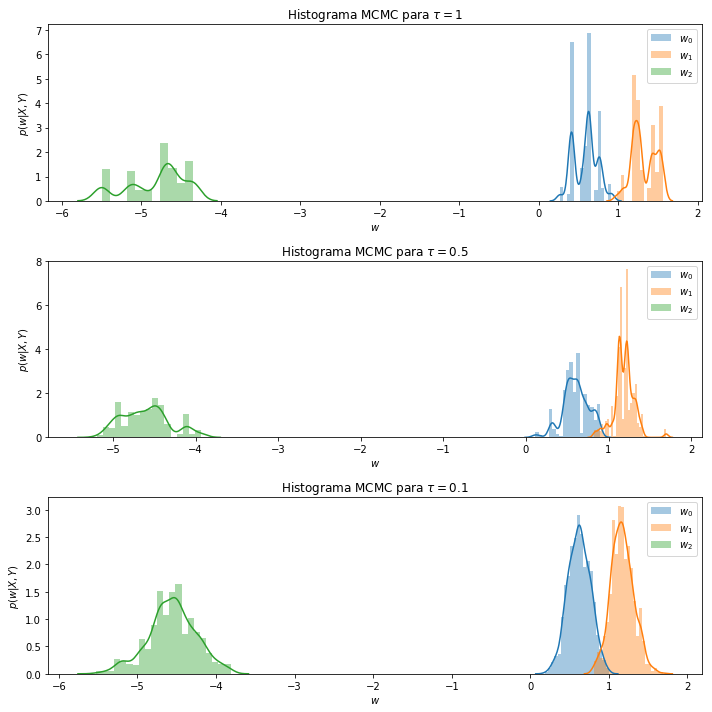

In [8]:
n2burn = 100
plt.figure(figsize=(10,10))
for i in range(len(tau_array)):   
    plt.subplot(3, 1, i+1)
    sns.distplot(mcmc_samples[i][:,0][n2burn:], label=r'$w_0$')
    sns.distplot(mcmc_samples[i][:,1][n2burn:], label=r'$w_1$')
    sns.distplot(mcmc_samples[i][:,2][n2burn:], label=r'$w_2$')
    plt.title(r'Histograma MCMC para $\tau={}$'.format(tau_array[i]))
    plt.xlabel(r'$w$')
    plt.ylabel(r'$p(w|X,Y)$')
    plt.legend()
plt.tight_layout()
plt.savefig('04-histograms', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
def inference(x, samples):
    prob = 0
    for i in range(len(samples)):
        prob += sig(samples[i], x)
    return prob / (i+1)

for i in range(len(tau_array)):
    y_pred = inference(X_test, mcmc_samples[i][n2burn:])
    print('Bayesian Logistic Regression Accuracy for Tau={}: {}'.format(tau_array[i], 
                                                                        accuracy_score(y_test, (y_pred >= 0.5).astype(int))))

Bayesian Logistic Regression Accuracy for Tau=1: 0.87
Bayesian Logistic Regression Accuracy for Tau=0.5: 0.87
Bayesian Logistic Regression Accuracy for Tau=0.1: 0.87
